In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
import logging
import mne 

from Function import *

In [2]:
# =============================================================================
# Configuration: Paths and Parameters
# =============================================================================
# Set up logging: messages will include timestamp, log level, and message content
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

PREPROCESSED_DATA_ROOT = '../data/preprocessData'

PATH_RESULTS_EPOCH = os.path.join('..', 'results', 'epoch')
PATH_RESULTS_ERP = os.path.join('..', 'results', 'erp')
PATH_RESULTS_JOINT = os.path.join('..', 'results', 'joint-modeling')

os.makedirs(PATH_RESULTS_EPOCH, exist_ok=True)
os.makedirs(PATH_RESULTS_ERP, exist_ok=True)
os.makedirs(PATH_RESULTS_JOINT, exist_ok=True)

BIDS_TASK_LABEL = '_task-randomDot'
BIDS_BEH_SUFFIX = '_beh'
BIDS_EEG_SUFFIX = '_eeg'

SAMPLING_RATE = 500
CHANNEL_INDICES = [54, 36, 86]

T_ERP_START, T_ERP_END = -1.0, 0.2
T_BASELINE_START, T_BASELINE_END = -1.0, -0.8
T_AMS_SLPS_START, T_AMS_SLPS_END = -0.18, -0.08
T_PAMS_START, T_PAMS_END = -0.05, 0.05

SUBJECT_DIR = [f'sub-A{i:03d}' for i in range(1, 21)]

In [3]:
# =============================================================================
# Process Each Subject 
# =============================================================================
data_erp_average_allSubj = []
data_joint_modeling_allSubj = []

for sub_id in SUBJECT_DIR:
    logger.info(f"\nProcessing subject: {sub_id}")

    # === Step 1: Load behavioral data ===
    path_behaviorData = os.path.join(PREPROCESSED_DATA_ROOT, sub_id, 'beh', sub_id+BIDS_TASK_LABEL+BIDS_BEH_SUFFIX+'.tsv')
    data_behavior = pd.read_csv(path_behaviorData, sep='\t', header=0)
    n_behavior_trials = len(data_behavior)
    logger.info(f"  - Behavioral trials: {n_behavior_trials}")
    assert n_behavior_trials > 0, f"No behavioral data found for subject {sub_id}"

    # === Step 2: Load EEG file ===
    path_eeg = os.path.join(
        PREPROCESSED_DATA_ROOT,
        sub_id,
        'eeg',
        f"{sub_id}{BIDS_TASK_LABEL}{BIDS_EEG_SUFFIX}.vhdr"
    )
    assert os.path.exists(path_eeg), f"EEG file not found: {path_eeg}"

    eeg_bids = mne.io.read_raw_brainvision(path_eeg, preload=False)
    events, event_id = mne.events_from_annotations(eeg_bids)

    # === step 3: Validate that response event exists ===
    event_key_response = 'Stimulus/S  5'
    assert event_key_response in event_id, f"Response event '{event_key_response}' not found in annotations for {sub_id}"
    event_id_response = {event_key_response: event_id[event_key_response]}
    events_response = events[events[:, 2] == event_id_response[event_key_response]]

    # === step 4: Ensure behavior data and eeg data have the same trials
    n_eeg_trials = len(events_response)
    logger.info(f"  - EEG response-locked trials: {n_eeg_trials}")
    assert n_eeg_trials == n_behavior_trials, "Trial count mismatch! EEG: {n_eeg_trials}, Behavior: {n_behavior_trials}"

    # === step5: Full ERP epoching
    eeg_epochs = mne.Epochs(
        raw = eeg_bids, 
        events = events_response, 
        event_id = event_id_response,
        tmin = T_ERP_START, tmax = T_ERP_END,
        baseline = None, 
        preload=True
    )
    assert eeg_epochs.get_data().shape[0] == n_eeg_trials, "Epoch count mismatch after epoching"

    # Save epoched data 
    data_eeg_epochs = eeg_epochs.get_data()
    assert not np.isnan(data_eeg_epochs).all(), "All EEG data is NaN — check preprocessing pipeline"
    scipy.io.savemat(os.path.join(PATH_RESULTS_EPOCH, f'epoch_{sub_id}.mat'), {'EEG_epoch': data_eeg_epochs})

    # Extract and save ERP
    data_erp = eeg_epochs.get_data(picks=CHANNEL_INDICES)
    assert data_erp.shape[1] == len(CHANNEL_INDICES), "Channel selection failed"
    scipy.io.savemat(os.path.join(PATH_RESULTS_ERP, f'erp_{sub_id}.mat'), {'erp': data_erp})
    
    # Calculate CPP by averaging the erp above
    data_erp_average = np.nanmean(data_erp, axis=(0, 1))
    data_erp_average_allSubj.append(data_erp_average)
    
    # === step 6: Extraction AMS, PAMS and SLPS for joint modeling
    # AMS & SLPS window
    eeg_epochs_ams_slps = mne.Epochs(
        raw = eeg_bids, 
        events = events_response, 
        event_id = event_id_response,
        tmin=T_AMS_SLPS_START, tmax=T_AMS_SLPS_END,
        baseline = None, 
        preload=True
    )
    data_ams_slps = eeg_epochs_ams_slps.get_data(picks=CHANNEL_INDICES)
    data_ams_slps_average = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)

    # PAMS window
    eeg_epochs_pams = mne.Epochs(
        raw = eeg_bids, 
        events = events_response, 
        event_id = event_id_response,
        tmin=T_PAMS_START, tmax=T_PAMS_END,
        baseline = None,
        preload = True
    )
    data_pams = eeg_epochs_pams.get_data(picks=CHANNEL_INDICES)
    data_pams_average = np.nanmean(data_pams, axis=1)

    # SLPS: smoothing and slope
    data_slps = pd.DataFrame(data_ams_slps_average)
    data_slps_smooth = smooth(data_slps, sample_rate=SAMPLING_RATE)
    assert data_slps_smooth.shape == data_slps.shape, "Smoothing altered data shape"

    # Calculate each features 
    ams = np.nanmean(data_ams_slps_average, axis=1)
    pams = np.nanmax(data_pams_average, axis=1)

    n_trials = data_ams_slps_average.shape[0]
    slps = np.empty(n_trials)
    time_vector = np.arange(data_slps_smooth.shape[1]) / SAMPLING_RATE
    for i in range(n_trials):
        y = data_slps_smooth.iloc[i, :]
        slope = np.polyfit(time_vector, y, deg=1)[0]        
        slps[i] = slope
            
    # Validation: no all-NaN features
    assert not np.all(np.isnan(ams)), "All AMS values are NaN"
    assert not np.all(np.isnan(pams)), "All PAMS values are NaN"
    assert not np.all(np.isnan(slps)), "All SLPS values are NaN"

    # Combine each features
    data_features = pd.DataFrame({
        'ams': ams,
        'pams': pams,
        'slps': slps
    })
    assert len(data_features) == n_behavior_trials, "Feature extraction altered trial count"

    # Merge with behavior and features
    data_joint_modeling_subj = pd.concat([data_features, data_behavior], axis=1)
    data_joint_modeling_subj['subj'] = sub_id
    data_joint_modeling_allSubj.append(data_joint_modeling_subj)

    logger.info(f"Subject {sub_id} completed.")


# =============================================================================
# Aggregate and Finalize with Group-Level Validation
# =============================================================================

data_joint_modeling_allSubj = pd.concat(data_joint_modeling_allSubj, ignore_index=True)
logger.info(f"\nAggregated dataset: {data_joint_modeling_allSubj.shape[0]} trials across {data_joint_modeling_allSubj['subj'].nunique()} subjects.")


2025-12-09 14:20:06,065 - INFO - 
Processing subject: sub-A001
2025-12-09 14:20:06,071 - INFO -   - Behavioral trials: 281


Extracting parameters from ../data/preprocessData/sub-A001/eeg/sub-A001_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:07,269 - INFO -   - EEG response-locked trials: 281


Not setting metadata
281 matching events found
No baseline correction applied
0 projection items activated
Loading data for 281 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
281 matching events found
No baseline correction applied
0 projection items activated
Loading data for 281 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
281 matching events found
No baseline correction applied
0 projection items activated
Loading data for 281 events and 51 original time points ...
0 bad epochs dropped


2025-12-09 14:20:07,734 - INFO - Subject sub-A001 completed.
2025-12-09 14:20:07,734 - INFO - 
Processing subject: sub-A002
2025-12-09 14:20:07,736 - INFO -   - Behavioral trials: 293


Extracting parameters from ../data/preprocessData/sub-A002/eeg/sub-A002_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:07,755 - INFO -   - EEG response-locked trials: 293


Not setting metadata
293 matching events found
No baseline correction applied
0 projection items activated
Loading data for 293 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
293 matching events found
No baseline correction applied
0 projection items activated
Loading data for 293 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
293 matching events found
No baseline correction applied
0 projection items activated
Loading data for 293 events and 51 original time points ...
0 bad epochs dropped


2025-12-09 14:20:08,231 - INFO - Subject sub-A002 completed.
2025-12-09 14:20:08,231 - INFO - 
Processing subject: sub-A003
2025-12-09 14:20:08,233 - INFO -   - Behavioral trials: 280


Extracting parameters from ../data/preprocessData/sub-A003/eeg/sub-A003_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:08,251 - INFO -   - EEG response-locked trials: 280


Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Loading data for 280 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Loading data for 280 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Loading data for 280 events and 51 original time points ...
0 bad epochs dropped


2025-12-09 14:20:08,691 - INFO - Subject sub-A003 completed.
2025-12-09 14:20:08,692 - INFO - 
Processing subject: sub-A004
2025-12-09 14:20:08,694 - INFO -   - Behavioral trials: 277


Extracting parameters from ../data/preprocessData/sub-A004/eeg/sub-A004_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:08,713 - INFO -   - EEG response-locked trials: 277


Not setting metadata
277 matching events found
No baseline correction applied
0 projection items activated
Loading data for 277 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
277 matching events found
No baseline correction applied
0 projection items activated
Loading data for 277 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
277 matching events found
No baseline correction applied
0 projection items activated
Loading data for 277 events and 51 original time points ...
0 bad epochs dropped


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:76: RuntimeWarning: Mean of empty slice
  data_ams_slps_average = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
2025-12-09 14:20:09,136 - INFO - Subject sub-A004 completed.
2025-12-09 14:20:09,136 - INFO - 
Processing subject: sub-A005
2025-12-09 14:20:09,139 - INFO -   - Behavioral trials: 281


Extracting parameters from ../data/preprocessData/sub-A005/eeg/sub-A005_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:09,178 - INFO -   - EEG response-locked trials: 281


Not setting metadata
281 matching events found
No baseline correction applied
0 projection items activated
Loading data for 281 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
281 matching events found
No baseline correction applied
0 projection items activated
Loading data for 281 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
281 matching events found
No baseline correction applied
0 projection items activated
Loading data for 281 events and 51 original time points ...
0 bad epochs dropped


2025-12-09 14:20:09,606 - INFO - Subject sub-A005 completed.
2025-12-09 14:20:09,606 - INFO - 
Processing subject: sub-A006
2025-12-09 14:20:09,608 - INFO -   - Behavioral trials: 306


Extracting parameters from ../data/preprocessData/sub-A006/eeg/sub-A006_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:09,632 - INFO -   - EEG response-locked trials: 306


Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Loading data for 306 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Loading data for 306 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Loading data for 306 events and 51 original time points ...
0 bad epochs dropped


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:76: RuntimeWarning: Mean of empty slice
  data_ams_slps_average = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:88: RuntimeWarning: Mean of empty slice
  data_pams_average = np.nanmean(data_pams, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:96: RuntimeWarning: Mean of empty slice
  ams = np.nanmean(data_ams_slps_average, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:97: RuntimeWarning: All-NaN slice encountered
  pams = np.nanmax(data_pams_average, axis=1)
2025-12-09 14:20:10,113 - INFO - Subject sub-A006 completed.
2025-12-09 14:20:10,113 - INFO - 
Processing subject: sub-A007
2025-12-09 14:20:10,115 - INFO -   - Behavioral trials: 294


Extracting parameters from ../data/preprocessData/sub-A007/eeg/sub-A007_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:10,138 - INFO -   - EEG response-locked trials: 294


Not setting metadata
294 matching events found
No baseline correction applied
0 projection items activated
Loading data for 294 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
294 matching events found
No baseline correction applied
0 projection items activated
Loading data for 294 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
294 matching events found
No baseline correction applied
0 projection items activated
Loading data for 294 events and 51 original time points ...
0 bad epochs dropped


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:76: RuntimeWarning: Mean of empty slice
  data_ams_slps_average = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:88: RuntimeWarning: Mean of empty slice
  data_pams_average = np.nanmean(data_pams, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:96: RuntimeWarning: Mean of empty slice
  ams = np.nanmean(data_ams_slps_average, axis=1)
2025-12-09 14:20:10,606 - INFO - Subject sub-A007 completed.
2025-12-09 14:20:10,606 - INFO - 
Processing subject: sub-A008
2025-12-09 14:20:10,608 - INFO -   - Behavioral trials: 318


Extracting parameters from ../data/preprocessData/sub-A008/eeg/sub-A008_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:10,630 - INFO -   - EEG response-locked trials: 318


Not setting metadata
318 matching events found
No baseline correction applied
0 projection items activated
Loading data for 318 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
318 matching events found
No baseline correction applied
0 projection items activated
Loading data for 318 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
318 matching events found
No baseline correction applied
0 projection items activated
Loading data for 318 events and 51 original time points ...
0 bad epochs dropped


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:76: RuntimeWarning: Mean of empty slice
  data_ams_slps_average = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:88: RuntimeWarning: Mean of empty slice
  data_pams_average = np.nanmean(data_pams, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:96: RuntimeWarning: Mean of empty slice
  ams = np.nanmean(data_ams_slps_average, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:97: RuntimeWarning: All-NaN slice encountered
  pams = np.nanmax(data_pams_average, axis=1)
2025-12-09 14:20:11,171 - INFO - Subject sub-A008 completed.
2025-12-09 14:20:11,171 - INFO - 
Processing subject: sub-A009
2025-12-09 14:20:11,175 - INFO -   - Behavioral trials: 262


Extracting parameters from ../data/preprocessData/sub-A009/eeg/sub-A009_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:11,196 - INFO -   - EEG response-locked trials: 262


Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated
Loading data for 262 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated
Loading data for 262 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated
Loading data for 262 events and 51 original time points ...
0 bad epochs dropped


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:76: RuntimeWarning: Mean of empty slice
  data_ams_slps_average = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:88: RuntimeWarning: Mean of empty slice
  data_pams_average = np.nanmean(data_pams, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:97: RuntimeWarning: All-NaN slice encountered
  pams = np.nanmax(data_pams_average, axis=1)
2025-12-09 14:20:11,596 - INFO - Subject sub-A009 completed.
2025-12-09 14:20:11,596 - INFO - 
Processing subject: sub-A010
2025-12-09 14:20:11,598 - INFO -   - Behavioral trials: 258


Extracting parameters from ../data/preprocessData/sub-A010/eeg/sub-A010_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:11,619 - INFO -   - EEG response-locked trials: 258


Not setting metadata
258 matching events found
No baseline correction applied
0 projection items activated
Loading data for 258 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
258 matching events found
No baseline correction applied
0 projection items activated
Loading data for 258 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
258 matching events found
No baseline correction applied
0 projection items activated
Loading data for 258 events and 51 original time points ...
0 bad epochs dropped


2025-12-09 14:20:12,016 - INFO - Subject sub-A010 completed.
2025-12-09 14:20:12,016 - INFO - 
Processing subject: sub-A011
2025-12-09 14:20:12,019 - INFO -   - Behavioral trials: 312


Extracting parameters from ../data/preprocessData/sub-A011/eeg/sub-A011_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:12,041 - INFO -   - EEG response-locked trials: 312


Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Loading data for 312 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Loading data for 312 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Loading data for 312 events and 51 original time points ...
0 bad epochs dropped


2025-12-09 14:20:12,512 - INFO - Subject sub-A011 completed.
2025-12-09 14:20:12,512 - INFO - 
Processing subject: sub-A012
2025-12-09 14:20:12,514 - INFO -   - Behavioral trials: 285


Extracting parameters from ../data/preprocessData/sub-A012/eeg/sub-A012_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:12,537 - INFO -   - EEG response-locked trials: 285


Not setting metadata
285 matching events found
No baseline correction applied
0 projection items activated
Loading data for 285 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
285 matching events found
No baseline correction applied
0 projection items activated
Loading data for 285 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
285 matching events found
No baseline correction applied
0 projection items activated
Loading data for 285 events and 51 original time points ...
0 bad epochs dropped


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:76: RuntimeWarning: Mean of empty slice
  data_ams_slps_average = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:88: RuntimeWarning: Mean of empty slice
  data_pams_average = np.nanmean(data_pams, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:96: RuntimeWarning: Mean of empty slice
  ams = np.nanmean(data_ams_slps_average, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:97: RuntimeWarning: All-NaN slice encountered
  pams = np.nanmax(data_pams_average, axis=1)
2025-12-09 14:20:12,958 - INFO - Subject sub-A012 completed.
2025-12-09 14:20:12,958 - INFO - 
Processing subject: sub-A013
2025-12-09 14:20:12,960 - INFO -   - Behavioral trials: 288


Extracting parameters from ../data/preprocessData/sub-A013/eeg/sub-A013_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:12,983 - INFO -   - EEG response-locked trials: 288


Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 51 original time points ...
0 bad epochs dropped


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:76: RuntimeWarning: Mean of empty slice
  data_ams_slps_average = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
2025-12-09 14:20:13,410 - INFO - Subject sub-A013 completed.
2025-12-09 14:20:13,411 - INFO - 
Processing subject: sub-A014
2025-12-09 14:20:13,412 - INFO -   - Behavioral trials: 311


Extracting parameters from ../data/preprocessData/sub-A014/eeg/sub-A014_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:13,433 - INFO -   - EEG response-locked trials: 311


Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
Loading data for 311 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
Loading data for 311 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
Loading data for 311 events and 51 original time points ...
0 bad epochs dropped


2025-12-09 14:20:13,880 - INFO - Subject sub-A014 completed.
2025-12-09 14:20:13,880 - INFO - 
Processing subject: sub-A015
2025-12-09 14:20:13,882 - INFO -   - Behavioral trials: 299


Extracting parameters from ../data/preprocessData/sub-A015/eeg/sub-A015_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:13,901 - INFO -   - EEG response-locked trials: 299


Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Loading data for 299 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Loading data for 299 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Loading data for 299 events and 51 original time points ...
0 bad epochs dropped


2025-12-09 14:20:14,491 - INFO - Subject sub-A015 completed.
2025-12-09 14:20:14,491 - INFO - 
Processing subject: sub-A016
2025-12-09 14:20:14,493 - INFO -   - Behavioral trials: 302


Extracting parameters from ../data/preprocessData/sub-A016/eeg/sub-A016_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:14,519 - INFO -   - EEG response-locked trials: 302


Not setting metadata
302 matching events found
No baseline correction applied
0 projection items activated
Loading data for 302 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
302 matching events found
No baseline correction applied
0 projection items activated
Loading data for 302 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
302 matching events found
No baseline correction applied
0 projection items activated
Loading data for 302 events and 51 original time points ...
0 bad epochs dropped


2025-12-09 14:20:14,960 - INFO - Subject sub-A016 completed.
2025-12-09 14:20:14,960 - INFO - 
Processing subject: sub-A017
2025-12-09 14:20:14,964 - INFO -   - Behavioral trials: 287


Extracting parameters from ../data/preprocessData/sub-A017/eeg/sub-A017_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:14,983 - INFO -   - EEG response-locked trials: 287


Not setting metadata
287 matching events found
No baseline correction applied
0 projection items activated
Loading data for 287 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
287 matching events found
No baseline correction applied
0 projection items activated
Loading data for 287 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
287 matching events found
No baseline correction applied
0 projection items activated
Loading data for 287 events and 51 original time points ...
0 bad epochs dropped


2025-12-09 14:20:15,401 - INFO - Subject sub-A017 completed.
2025-12-09 14:20:15,401 - INFO - 
Processing subject: sub-A018
2025-12-09 14:20:15,404 - INFO -   - Behavioral trials: 261


Extracting parameters from ../data/preprocessData/sub-A018/eeg/sub-A018_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:15,424 - INFO -   - EEG response-locked trials: 261


Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated
Loading data for 261 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated
Loading data for 261 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated
Loading data for 261 events and 51 original time points ...
0 bad epochs dropped


2025-12-09 14:20:15,804 - INFO - Subject sub-A018 completed.
2025-12-09 14:20:15,804 - INFO - 
Processing subject: sub-A019
2025-12-09 14:20:15,805 - INFO -   - Behavioral trials: 297


Extracting parameters from ../data/preprocessData/sub-A019/eeg/sub-A019_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:15,835 - INFO -   - EEG response-locked trials: 297


Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
Loading data for 297 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
Loading data for 297 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
Loading data for 297 events and 51 original time points ...
0 bad epochs dropped


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:76: RuntimeWarning: Mean of empty slice
  data_ams_slps_average = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/3639181825.py:88: RuntimeWarning: Mean of empty slice
  data_pams_average = np.nanmean(data_pams, axis=1)
2025-12-09 14:20:16,296 - INFO - Subject sub-A019 completed.
2025-12-09 14:20:16,296 - INFO - 
Processing subject: sub-A020
2025-12-09 14:20:16,298 - INFO -   - Behavioral trials: 276


Extracting parameters from ../data/preprocessData/sub-A020/eeg/sub-A020_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]


2025-12-09 14:20:16,318 - INFO -   - EEG response-locked trials: 276


Not setting metadata
276 matching events found
No baseline correction applied
0 projection items activated
Loading data for 276 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
276 matching events found
No baseline correction applied
0 projection items activated
Loading data for 276 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
276 matching events found
No baseline correction applied
0 projection items activated
Loading data for 276 events and 51 original time points ...
0 bad epochs dropped


2025-12-09 14:20:16,722 - INFO - Subject sub-A020 completed.
2025-12-09 14:20:16,728 - INFO - 
Aggregated dataset: 5768 trials across 20 subjects.


In [4]:
# =============================================================================
# Calculate joint modeling under bins
# =============================================================================

# ===S tep 1: Quantile binning based on ORIGINAL values ===
for feature in ['ams', 'pams', 'slps']:
    quantile_col = f"{feature}_quantile"
    
    def safe_qcut_original(x):
        # x is the ORIGINAL feature values
        x_clean = x.dropna()
        if x_clean.nunique() < 4:
            return pd.Series(['N/A'] * len(x), index=x.index)
        try:
            return pd.qcut(x, q=4, labels=['1st', '2nd', '3rd', '4th'])
        except Exception:
            return pd.Series(['N/A'] * len(x), index=x.index)
    
    data_joint_modeling_allSubj[quantile_col] = data_joint_modeling_allSubj.groupby('subj')[feature].transform(safe_qcut_original)

# === Step 2: Convert ORIGINAL values to z-scores ===
for feature in ['ams', 'pams', 'slps']:
    def safe_zscore(x):
        x_clean = x.dropna()
        if len(x_clean) < 2:
            return pd.Series(np.nan, index=x.index)
        return (x - x.mean()) / x.std()
    data_joint_modeling_allSubj[feature] = data_joint_modeling_allSubj.groupby('subj')[feature].transform(safe_zscore)

# === Step 3: Compute bin means of the Z-SCORED values ===
for feature in ['ams', 'pams', 'slps']:
    quantile_col = f"{feature}_quantile"
    bin_col = 'slp_bin' if feature == 'slps' else f"{feature[:3]}_bin"
    
    # Group by subject and quantile, take mean of z-scored feature
    bin_means = data_joint_modeling_allSubj.groupby(['subj', quantile_col])[feature].mean().reset_index()
    bin_means.rename(columns={feature: bin_col}, inplace=True)
    
    # Merge back: each trial gets the mean z-score of its bin
    data_joint_modeling_allSubj = pd.merge(data_joint_modeling_allSubj, bin_means, on=['subj', quantile_col], how='left')

# === step 4: Save the joint modeling data===
output_path = os.path.join(PATH_RESULTS_JOINT, 'data_joint_modeling_allSubj.csv')
data_joint_modeling_allSubj.to_csv(output_path, index=False)
logger.info(f"\n✅ Processing completed successfully. Output saved to:\n{output_path}")

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/4183995636.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_joint_modeling_allSubj.groupby(['subj', quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/4183995636.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_joint_modeling_allSubj.groupby(['subj', quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_26862/4183995636.py:36: FutureWarning: The default of observed=False is deprecated and will be 

# Plot
The following codes aim to plot response-locked CPP data in the rang of [-1, 0.2]

In [5]:
def plot_erp_results(erp, times, ylim=[-10, 10], labelpad=0):

    """
    参数：
        erp: shape为[n_subs, n_times]的矩阵，对应每个被试的ERP
        times: shape为[n_times]的array，代表时间点（对应x轴的时间范围及时间点）
        ylim：Y轴范围，默认[-10, 10]
        labelpad：Y轴标签离坐标轴的距离，默认0
    """

    n_subjects = np.shape(erp)[0]

    # 平均ERPs
    avg = np.average(erp, axis=0)
    # 计算逐时间点的SEM
    err = np.std(erp, axis=0, ddof=0)/np.sqrt(n_subjects)
    
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0))

    # 绘制ERP
    plt.fill_between(times, avg+err, avg-err, alpha=0.2)
    plt.plot(times, avg, alpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.ylabel(r'Amplitude in $\mu$V', fontsize=16, labelpad=labelpad)
    #plt.xlabel('Time (s)', fontsize=16)
    plt.ylim(ylim[0], ylim[1])
    plt.show()

In [6]:
data_plot = np.array(data_erp_average_allSubj)

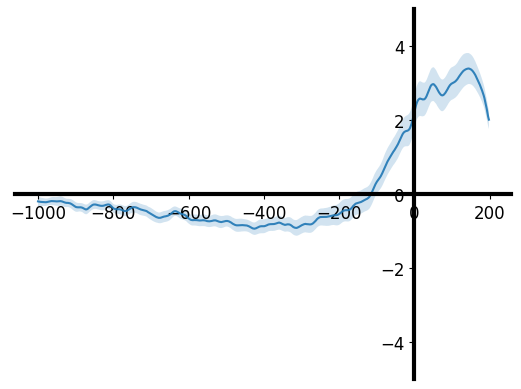

In [7]:
times = np.arange(-1000, 200, 1200/601)
plot_erp_results(data_plot, times, ylim=[-5,5],labelpad=25)